<a href="https://colab.research.google.com/github/niikun/ai_engineering_day3/blob/main/Week3_HomeWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 宿題3週目

## モデルなど準備

In [ ]:
!pip install -q --upgrade transformers
!pip install -q google-colab-selenium
!pip install -q bitsandbytes

In [ ]:
!pip install langchain-community langchain_chroma langchain_openai

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!pip install japanize_matplotlib

In [ ]:
# CUDAが利用可能ならGPUを、それ以外ならCPUをデバイスとして設定
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import numpy as np
import random
random.seed(0)

### モデル Llama-3-8B-Instruct

In [ ]:
from transformers import AutoModelForCausalLM,AutoTokenizer,BitsAndBytesConfig

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=False,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16
)

### Generate_output

In [ ]:
def generate_output(query,system_prompt=None):

    if system_prompt is None:
        messages = [
            {"role":"user","content":query}
        ]
    else:
        messages = [
            {"role":"system","content":system_prompt},
            {"role":"user","content":query}
        ]
    input_ids = tokenizer.apply_chat_template(
        messages,
        # モデルに「ここからあなたが続きを書いてね」という合図（生成用プロンプト）を自動で最後に付け加えます。
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    # terminators は、モデルが「ここで文章を終わり」と判断するための「終端トークン」のIDをまとめたリスト。
    terminators = [
        # もともと用意されている「End Of Sequence（EOS）」トークンのID
        tokenizer.eos_token_id,
        # 独自に「End Of Turn（EOT）」などの特別な終端マーカー <|eot_id|> を定義している場合、その文字列を対応する数値IDに変換
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    outputs = model.generate(
        input_ids,
        max_new_tokens=256,
        eos_token_id=terminators,
        # False:greedy生成=最も確率の高い次のトークンを選ぶ。Trueの場合はランダムサンプリングを行いバリエーション出す
        do_sample=False,
    )
    response = outputs[0][input_ids.shape[-1]:]
    return tokenizer.decode(response,skip_special_tokens=True)

### evaluate_answer_accuracy

In [ ]:
!pip install -U openai

In [ ]:
from openai import OpenAI
from google.colab import userdata
OPEN_AI_API_KEY = userdata.get("OPENAI_API_KEY")
client = OpenAI(api_key=OPEN_AI_API_KEY, max_retries=5, timeout=60)

def openai_generator(query):
    messages = [
        {
            "role":"user",
            "content":query
        }
    ]
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages
    )
    return response.choices[0].message.content

def evaluate_answer_accuracy(query, response, reference):

    template_accuracy1 = (
          "Instruction: You are a world class state of the art assistant for rating "
          "a User Answer given a Question. The Question is completely answered by the Reference Answer.\n"
          "Say 4, if User Answer is full contained and equivalent to Reference Answer"
          "in all terms, topics, numbers, metrics, dates and units.\n"
          "Say 2, if User Answer is partially contained and almost equivalent to Reference Answer"
          "in all terms, topics, numbers, metrics, dates and units.\n"
          "Say 0, if User Answer is not contained in Reference Answer or not accurate in all terms, topics,"
          "numbers, metrics, dates and units or the User Answer do not answer the question.\n"
          "Do not explain or justify your rating. Your rating must be only 4, 2 or 0 according to the instructions above.\n"
          "Even small discrepancies in meaning, terminology, directionality, or implication must result in a lower score. Only rate 4 if the User Answer is a complete and precise match to the Reference Answer in every aspect.\n"
          "### Question: {query}\n"
          "### {answer0}: {sentence_inference}\n"
          "### {answer1}: {sentence_true}\n"
          "The rating is:\n"
      )
    template_accuracy2 = (
          "I will rate the User Answer in comparison to the Reference Answer for a given Question.\n"
          "A rating of 4 indicates that the User Answer is entirely consistent with the Reference Answer, covering all aspects, topics, numbers, metrics, dates, and units.\n"
          "A rating of 2 signifies that the User Answer is mostly aligned with the Reference Answer, with minor discrepancies in some areas.\n"
          "A rating of 0 means that the User Answer is either inaccurate, incomplete, or unrelated to the Reference Answer, or it fails to address the Question.\n"
          "I will provide the rating without any explanation or justification, adhering to the following scale: 0 (no match), 2 (partial match), 4 (exact match).\n"
          "Even minor inconsistencies in meaning, terminology, emphasis, or factual detail should prevent a rating of 4. Only assign a 4 if the User Answer exactly and unambiguously matches the Reference Answer in every respect."
          "Do not explain or justify my rating. My rating must be only 4, 2 or 0 only.\n\n"
          "Question: {query}\n\n"
          "{answer0}: {sentence_inference}\n\n"
          "{answer1}: {sentence_true}\n\n"
          "Rating: "
      )

    score1 = openai_generator(
                template_accuracy1.format(
                      query=query,
                      answer0="User Answer",
                      answer1="Reference Answer",
                      sentence_inference=response,
                      sentence_true=reference,
                    )
                )
    try:
      score1 = int(score1)
    except:
      print("Failed")
      score1 = 0

    score2 = openai_generator(
                template_accuracy2.format(
                        query=query,
                        answer0="Reference Answer",
                        answer1="User Answer",
                        sentence_inference=reference,
                        sentence_true=response,
                    )
                  )

    try:
      score2 = int(score2)
    except:
      print("Failed")
      score2 = 0


    return (score1 + score2) / 2

## RAG準備

In [ ]:
from sentence_transformers import SentenceTransformer

emb_model = SentenceTransformer("infly/inf-retriever-v1-1.5b", trust_remote_code=True)
# emb_model = SentenceTransformer("all-MiniLM-L6-v2", trust_remote_code=True)
emb_model.max_seq_length = 8192

### 2-1 Simple RAG

初期RAG実装（ベーシックアプローチ）:
- **分割方法:** 「。」（句点）で区切られた文単位でテキストを分割
- **検索手法:** シンプルな類似度ベースの検索でクエリに関連する文を抽出
- **制約条件:** モデルの入力トークン制限に収まるよう関連文のみを選択

In [ ]:
def no_rag(query):
    system_prompt = "質問に回答してください。必ず「日本語で回答」すること。"
    question=f"[質問] {query}"
    return generate_output(query,system_prompt),None

In [ ]:
def simple_rag(query,texts,topk=5):

    documents = [text.strip() for text in texts.split("。")]
    query = query

    query_embeddings = emb_model.encode([query],prompt_name="query")
    document_embeddings = emb_model.encode(documents)
    scores = (query_embeddings @ document_embeddings.T) * 100
    reference = "\n".join(["*" + documents[i] for i in scores.argsort()[0][::-1][:topk]])
    system_prompt = "質問に回答してください。必ず「日本語で回答」すること。また、与えられる資料を参考にして回答すること。"
    question = f"[参考資料]\n{reference}\n\n[質問] {query}"
    response = generate_output(question,system_prompt)
    return response,reference

### 2-2 Context RAG
* **前後文脈を含むチャンク化**:
  - 検索でマッチした文だけでなく、その前後の複数文も含めてチャンクとして取得
  - 具体的には、マッチした文を中心に前2文、後2文を含む計5文程度のチャンクを構成
  - この「文脈ウィンドウ」により、発言の背景情報や議論の流れが保持される

* **期待される効果**:
  - 講師の主張とその根拠の関係性を正確に把握できる
  - 概念の定義とその適用範囲を正しく理解できる

In [ ]:
def context_rag(query,texts,topk=5):

    documents = [text.strip() for text in texts.split("。")]
    query = query

    query_embeddings = emb_model.encode([query],prompt_name="query")
    document_embeddings = emb_model.encode(documents)
    scores = (query_embeddings @ document_embeddings.T) * 100
    # 前後2つずつの文章を追加
    scores_vec = scores[0]
    topk_indices = np.argsort(scores_vec)[::-1][:topk]
    references = "\n".join(
    "*" + "。".join(
        documents[max(0, i-2) : min(i+3, len(documents))]
    )
    for i in topk_indices
    )
    system_prompt = "質問に回答してください。必ず「日本語で回答」すること。また、与えられる資料を参考にして回答すること。"
    question = f"[参考資料]\n{references}\n\n[質問] {query}"
    response = generate_output(question,system_prompt)
    return response,references

### 2-3 Rerankによる情報品質の向上
* **Rerank手法の導入**:
  - 第一段階: 従来通り基本的な検索アルゴリズムでtop-k個のドキュメントチャンクを取得
  - 第二段階: 取得したチャンクに対してLLMを活用した高度な関連性評価を実施
  - 関連性スコアに基づいてランク付けし、真に関連性の高いチャンクのみを選出

In [ ]:
def rerank_rag(query, texts, topk=5):
    # 文ごとに分割して空要素を除去
    documents = [sent.strip() for sent in texts.split("。") if sent.strip()]

    # 埋め込みとスコア計算
    query_embeddings = emb_model.encode([query], prompt_name="query")
    document_embeddings  = emb_model.encode(documents)
    scores = (query_embeddings @ document_embeddings.T).flatten() * 100

    # 上位 topk のインデックス
    topk_indices = np.argsort(scores)[::-1][:topk]

    # 前後2文ずつをくっつけてリファレンス候補を作成（先頭に * をつける）
    refs_list = []
    for i in topk_indices:
        start   = max(0, i - 2)
        end     = min(i + 3, len(documents))   # i, i+1, i+2 の３文を含む
        snippet = "。".join(documents[start:end])
        refs_list.append(f"*{snippet}")

    # 各候補が query に関連するか判定してフィルタリング
    filtered_refs = []
    for ref in refs_list:
        system_prompt = (
            "与えられた参考資料が質問に直接関連しているか？"
            "「yes」または「no」で答えること。余計なテキストを生成しないこと。"
        )
        question = f"[参考資料]\n{ref}\n\n[質問] {query}"
        response = generate_output(question, system_prompt)
        if "yes" in response.lower():
            filtered_refs.append(ref)

    # 最終回答
    system_prompt = (
        "質問に回答してください。必ず「日本語で回答」すること。"
        "また、与えられる資料を参考にして回答すること。"
    )
    # フィルタ済みリファレンスを改行でつなぐ
    references = "\n".join(filtered_refs)
    final_question = f"[参考資料]\n{references}\n\n[質問] {query}"
    return generate_output(final_question, system_prompt),references

##test


In [ ]:
# 演習用のコンテンツを取得
!git clone https://github.com/matsuolab/lecture-ai-engineering.git

Cloning into 'lecture-ai-engineering'...
remote: Enumerating objects: 52, done.
remote: Total 52 (delta 0), reused 0 (delta 0), pack-reused 52 (from 1)
Receiving objects: 100% (52/52), 83.21 KiB | 20.80 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
query = "LLMにおけるInference Time Scalingとは？"
gold_answer = "「Inference Time Scaling」とは、推論時に計算量を増やしてモデルの性能を高める手法です。これはモデルのサイズを大きくする代わりに、難しい入力に対して多くの計算リソースを使うことで、より良い出力を得ようとするアプローチです。"
with open("/content/lecture-ai-engineering/day3/data/LLM2024_day4.txt", "r") as f:
  tests = f.read()

- No RAG

In [ ]:
no_rag_response,ref = no_rag(query)
print(no_rag_response)
no_rag_score = evaluate_answer_accuracy(query, no_rag_response, gold_answer)

In [ ]:
results = {}

In [ ]:
results["no_rag"] = {}
results["no_rag"]["content"] = no_rag_response
results["no_rag"]["score"] = no_rag_score
print(results["no_rag"])
print("[Reference]")
print(ref)

- Simple RAG

In [ ]:
simple_rag_response,ref = simple_rag(query,tests)
print(simple_rag_response)
simple_rag_score = evaluate_answer_accuracy(query, simple_rag_response, gold_answer)

In [ ]:
results["simple_rag"] = {}
results["simple_rag"]["content"] = simple_rag_response
results["simple_rag"]["score"] = simple_rag_score
print(results["simple_rag"])
print("[Reference]")
print(ref)

- context RAG

In [ ]:
context_rag_response,ref = context_rag(query,tests)
print(context_rag_response)
context_rag_score = evaluate_answer_accuracy(query, context_rag_response, gold_answer)
print(context_rag_score)
print("[Reference]")
print(ref)

In [ ]:
results["context_rag"] = {}
results["context_rag"]["content"] = context_rag_response
results["context_rag"]["score"] = context_rag_score
print(results["context_rag"])

- Rerank RAG

In [ ]:
rerank_rag_response,ref = rerank_rag(query,tests)
print(rerank_rag_response)
rerank_rag_score = evaluate_answer_accuracy(query, rerank_rag_response, gold_answer)
print(rerank_rag_score)
print("[Reference]")
print(ref)

In [ ]:
results["rerank_rag"] = {}
results["rerank_rag"]["content"] = rerank_rag_response
results["rerank_rag"]["score"] = rerank_rag_score
print(results["rerank_rag"])

{'content': 'LLM（Large Language Model）におけるInference Time Scalingは、推論時（Inference）に計算資源をスケールすることで、性能を向上させることを意味します。具体的には、LLMが与えられた入力に対して、計算資源を増やすことで、より正確な結果を得ることができます。\n\nこの概念は、Google DeepMindの論文「Scaling LLM Test-Time Compute Optimally can be more Effective than Scaling More Parameters」に基づいています。この論文では、LLMの推論時計算資源をスケールすることで、性能を向上させることができることが示されました。\n\nInference Time Scalingは、LLMの推論時計算資源をスケールすることで、以下のような効果を期待できます。\n\n* 計算資源をスケールすることで、性能を向上させることができます。\n* 推論時計算資源をスケールすることで、計算量を減らすことができます。\n* LLMが与えられた入力に対して、より正確な結果を得ることができます。\n\nこの概念は、LLMの推論時計算資源をスケールする', 'score': 2.0}


In [ ]:
rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, tests)
    print("*"*40)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')

In [ ]:
for rag_type,result in zip(rag_types,results):
    print(rag_type.__name__)
    print(results[result]["score"])

#大谷翔平

### 参照文書①

In [ ]:
texts = """大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）。右投左打。MLBのロサンゼルス・ドジャース所属。妻は日本の元女子バスケットボール選手である。ポジションはセンター。
多くの野球関係者から、史上最高の野球選手の1人と評価されている。近代プロ野球では極めて稀なシーズンを通して投手と野手（または指名打者）を兼任する「二刀流（英: two-way player）」の選手である。
近代MLBにおいて1シーズンに規定投球回数と規定打席数の両方に到達した史上初の選手。MLB・NPB（日本プロ野球）両リーグで「1シーズンでの2桁勝利・2桁本塁打」を達成。NPBで最優秀選手を1度受賞、MLBでシーズンMVP（最優秀選手賞）を3度受賞。MLBにおいてアジア人初の本塁打王（2回）・打点王（1回）。MLB史上初の1シーズン50本塁打50盗塁（50-50）を達成。
MLBにおける通算本塁打数（現：225本、2024年終了時）、シーズン本塁打数（54本、2024年）、シーズン打点（130打点、2024年）、シーズン盗塁数（59個、2024年）のアジア人記録保持者。
2021年、タイム誌による「世界で最も影響力のある100人」に、「アイコン（象徴）」のカテゴリーで選出された。
2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した。
2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。
2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。
2024年に真美子さんとの結婚。ドジャーズ移籍1年目は打者で出場。元通訳との離別、前人未踏の「50-50（50本塁打、50盗塁）」達成など激動のシーズンとなった。メジャー7年目で初のポストシーズンにも進出し、悲願の世界一を達成。2024年度のフォーブスのスポーツ選手長者番付においては、スポンサー収入等の競技外収入がレブロン・ジェームズ、リオネル・メッシ、クリスティアーノ・ロナウド、ヤニス・アデトクンボに次いで世界5位であった。"""

##query = "大谷翔平の職業は何ですか？"


In [ ]:
gold_answer = "大谷翔平はプロ野球選手です"
query = "大谷翔平の職業は何ですか？"

In [ ]:
results = {}

rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, texts)
    print("*"*60)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')
    print("*"*60)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

df = pd.DataFrame(results).T
print(df)
sns.barplot(x=df.index, y="score", data=df)
plt.title(query)
plt.ylim(0, 4)
plt.show()

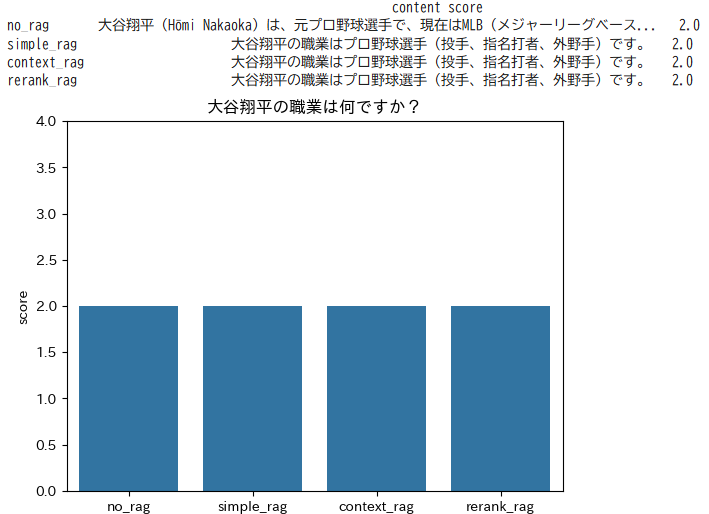

##query = "2024年の競技外収入は何位ですか？"


In [ ]:
gold_answer = "大谷翔平選手のスポンサー収入等の競技外収入は世界第5位であった。"
query = "2024年の競技外収入は何位ですか？"

In [ ]:
results = {}

rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, texts)
    print("*"*60)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')
    print("*"*60)

In [ ]:
df = pd.DataFrame(results).T
print(df)
sns.barplot(x=df.index, y="score", data=df)
plt.title(query)
plt.ylim(0, 4)
plt.show()

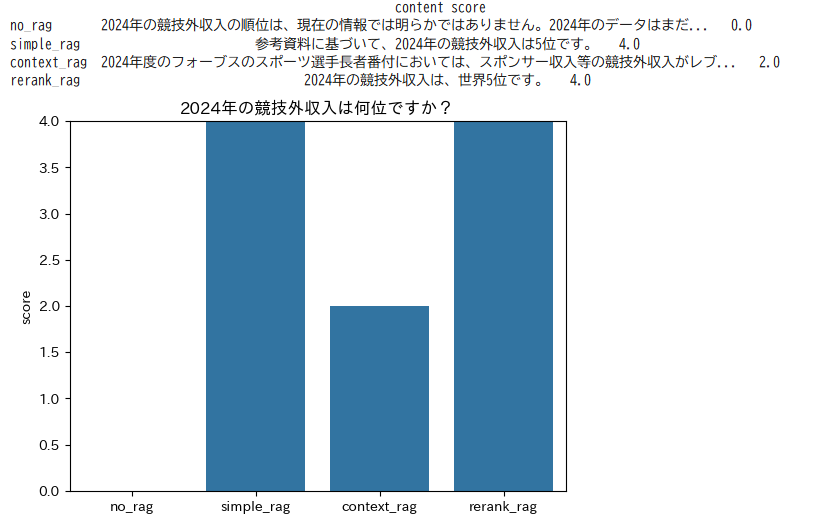

## query = "大谷翔平選手の配偶者の名前と過去のスポーツ経験を教えてください。"

In [ ]:
gold_answer = "大谷翔平選手の配偶者は真美子さん。元女子バスケットボール選手です。"
query = "大谷翔平選手の配偶者の名前と過去のスポーツ経験を教えてください。"

In [ ]:
results = {}

rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, texts)
    print("*"*60)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')
    print("*"*60)

In [ ]:
df = pd.DataFrame(results).T
print(df)
sns.barplot(x=df.index, y="score", data=df)
plt.title(query)
plt.ylim(0, 4)
plt.show()

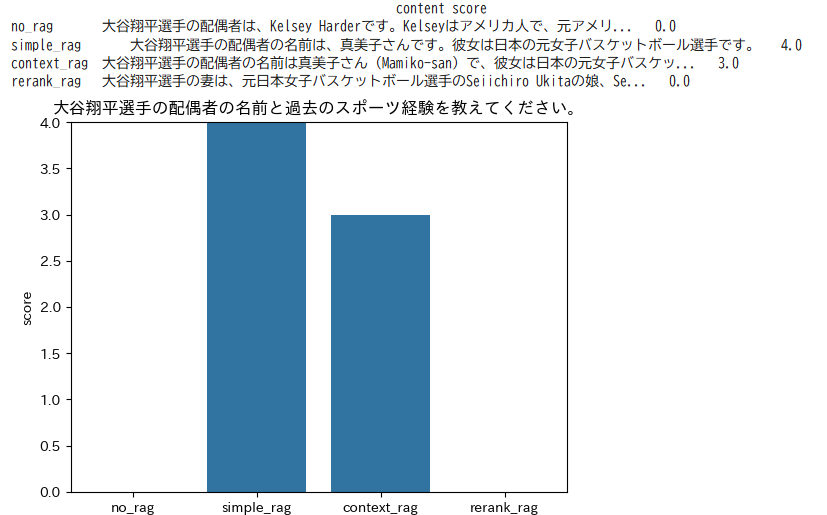

### query = "大谷翔平選手の妻の名前と過去のスポーツ経験を教えてください。"

In [ ]:
gold_answer = "大谷翔平選手の妻は真美子さん。元女子バスケットボール選手です。"
query = "大谷翔平選手の妻の名前と過去のスポーツ経験を教えてください。"

In [ ]:
results = {}

rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, texts)
    print("*"*60)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')
    print("*"*60)

In [ ]:
df = pd.DataFrame(results).T
print(df)
sns.barplot(x=df.index, y="score", data=df)
plt.title(query)
plt.ylim(0, 4)
plt.show()

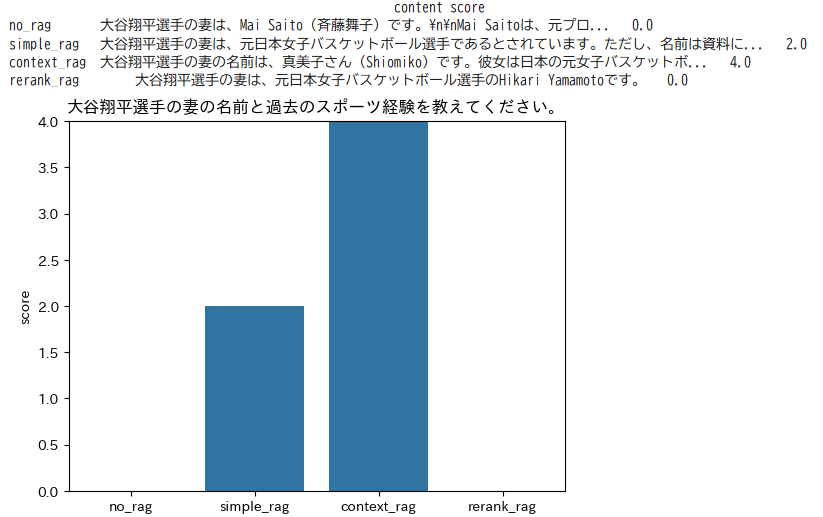

- 真美子さんの説明を前後に分けると、前半の情報をうまく取得できなかった。

## 参照文書② 真美子さんの記述をまとめる

In [ ]:
texts = """大谷 翔平（おおたに しょうへい、1994年〈平成6年〉7月5日 - ）は、岩手県水沢市（現：奥州市）出身のプロ野球選手（投手、指名打者、外野手）。右投左打。MLBのロサンゼルス・ドジャース所属。
多くの野球関係者から、史上最高の野球選手の1人と評価されている。近代プロ野球では極めて稀なシーズンを通して投手と野手（または指名打者）を兼任する「二刀流（英: two-way player）」の選手である。
近代MLBにおいて1シーズンに規定投球回数と規定打席数の両方に到達した史上初の選手。MLB・NPB（日本プロ野球）両リーグで「1シーズンでの2桁勝利・2桁本塁打」を達成。NPBで最優秀選手を1度受賞、MLBでシーズンMVP（最優秀選手賞）を3度受賞。MLBにおいてアジア人初の本塁打王（2回）・打点王（1回）。MLB史上初の1シーズン50本塁打50盗塁（50-50）を達成。
MLBにおける通算本塁打数（現：225本、2024年終了時）、シーズン本塁打数（54本、2024年）、シーズン打点（130打点、2024年）、シーズン盗塁数（59個、2024年）のアジア人記録保持者。
2021年、タイム誌による「世界で最も影響力のある100人」に、「アイコン（象徴）」のカテゴリーで選出された。
2021年から4年連続で日本人の好きなスポーツ選手で1位を獲得した。
2023年に開催されたワールド・ベースボール・クラシックでは、日本の優勝に貢献、自身もMVPを受賞した。
2023年12月にロサンゼルス・ドジャースと当時スポーツ史上最高額となる10年総額7億ドル（約1015億円）の契約を結んだ。
2024年に真美子さんとの結婚。彼女は元女子バスケットボール選手である。ポジションはセンター。ドジャーズ移籍1年目は打者で出場。元通訳との離別、前人未踏の「50-50（50本塁打、50盗塁）」達成など激動のシーズンとなった。メジャー7年目で初のポストシーズンにも進出し、悲願の世界一を達成。2024年度のフォーブスのスポーツ選手長者番付においては、スポンサー収入等の競技外収入がレブロン・ジェームズ、リオネル・メッシ、クリスティアーノ・ロナウド、ヤニス・アデトクンボに次いで世界5位であった。"""

### query = "大谷翔平選手の配偶者の名前と過去のスポーツ経験を教えてください。"

In [ ]:
gold_answer = "大谷翔平選手の配偶者は真美子さん。元女子バスケットボール選手です。"
query = "大谷翔平選手の配偶者の名前と過去のスポーツ経験を教えてください。"

In [ ]:
results = {}

rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, texts)
    print("*"*60)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')
    print("*"*60)

In [ ]:
df = pd.DataFrame(results).T
print(df)
sns.barplot(x=df.index, y="score", data=df)
plt.title(query)
plt.ylim(0, 4)
plt.show()

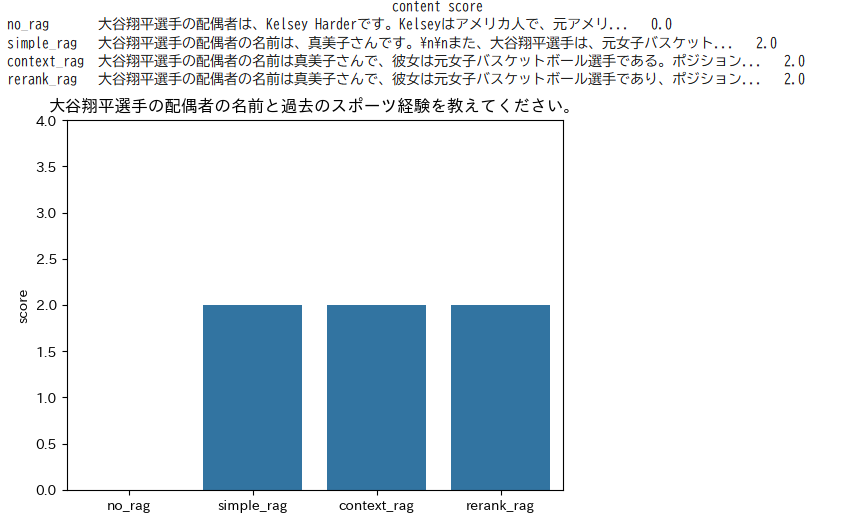

### query = "大谷翔平選手の妻の名前と過去のスポーツ経験を教えてください。"

In [ ]:
gold_answer = "大谷翔平選手の妻は真美子さん。元女子バスケットボール選手です。"
query = "大谷翔平選手の妻の名前と過去のスポーツ経験を教えてください。"

In [ ]:
results = {}

rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, texts)
    print("*"*60)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')
    print("*"*60)

In [ ]:
df = pd.DataFrame(results).T
print(df)
sns.barplot(x=df.index, y="score", data=df)
plt.title(query)
plt.ylim(0, 4)
plt.show()

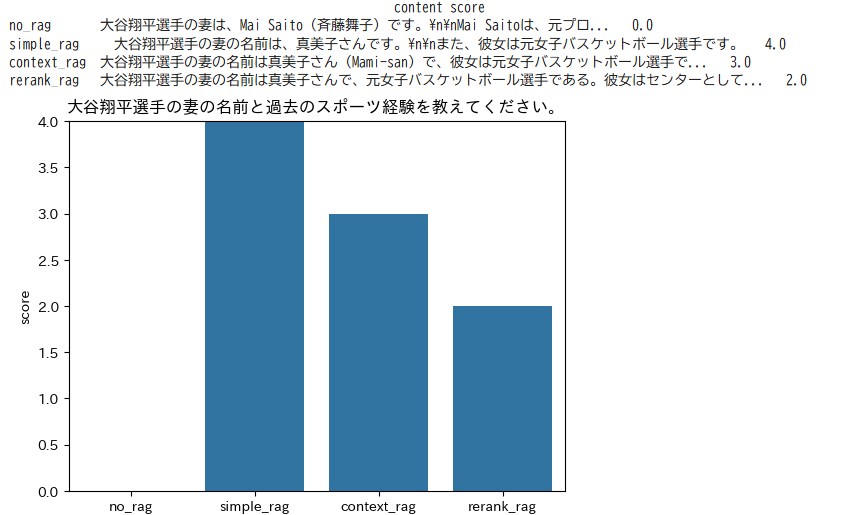

# 大阪・関西万博

- 生成AIでテキストを生成
- 文の最後のほうに来場客数を記載

In [ ]:
with open("/content/osaka_kansai_expo_overview.txt","r") as f:
    texts = f.read()

In [ ]:
texts

'## 概要\nExpo 2025 Osaka, Kansai は、国際博覧会事務局（BIE）が主催する世界万国博覧会で、2025年4月13日から10月13日まで、大阪市此花区の夢洲（Yumeshima）で開催される。前回1970年の大阪万博以来55年ぶりの開催であり、約155ヘクタールの会場に約28万人（※実際には2800万人を見込む）が来場すると予測されている。 \n\n## テーマ・サブテーマ\n- **テーマ**: 「Designing Future Society for Our Lives（私たちの暮らしと未来の社会のデザイン）」  \n- **サブテーマ**:  \n  - Saving Lives（命を救う）  \n  - Empowering Lives（人々を支える）  \n  - Connecting Lives（つながりを生む） \n\n## 会場・インフラ\n- **会場**: 人工島・夢洲（Yumeshima Island）。会場面積は約155ヘクタール（約383エーカー）。 \n- **主要構造物**:  \n  - グランドリング（Grand Ring）: 建築家藤本壮介氏設計による直径2kmの木製環状構造。展示とアートを融合した象徴的モニュメント。 \n- **交通アクセス**:  \n  - Osaka Metro中央線「夢洲駅」建設中。  \n  - 関西空港や大阪メトロ・JR線からシャトルバス運行予定。 \n\n## 参加者・パビリオン\n- **参加国・地域**: 約180カ国・地域が参加予定。 \n- **パビリオン数**: 約80の公式パビリオンと特別展示。 \n- **注目パビリオン例**:  \n  - 米国パビリオン: 宇宙旅行をテーマにした没入型展示。  \n  - ウクライナパビリオン: 戦時下の生活を記録・展示。  \n  - Cartier Women’s Pavilion: ジュエリーブランドによる女性とサステナビリティの融合展示。 \n## マスコット\n- **名前**: ミャクミャク（Myaku-Myaku）。カラフルで親しみやすいキャラクター。 \n\n## 来場者数予測・チケット\n- **予測来場者数**: 約2820万人。 \n- **チケット販売状況**: 開催2週間前で約900万人が前売

## query = "大阪・関西万博の会場はどこですか？"

In [ ]:
query = "大阪・関西万博の会場はどこですか？"
gold_answer = "大阪市此花区の夢洲です。"

In [ ]:
results = {}

rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, texts)
    print("*"*60)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')
    print("*"*60)

In [ ]:
df = pd.DataFrame(results).T
print(df)
sns.barplot(x=df.index, y="score", data=df)
plt.title(query)
plt.ylim(0, 4)
plt.show()

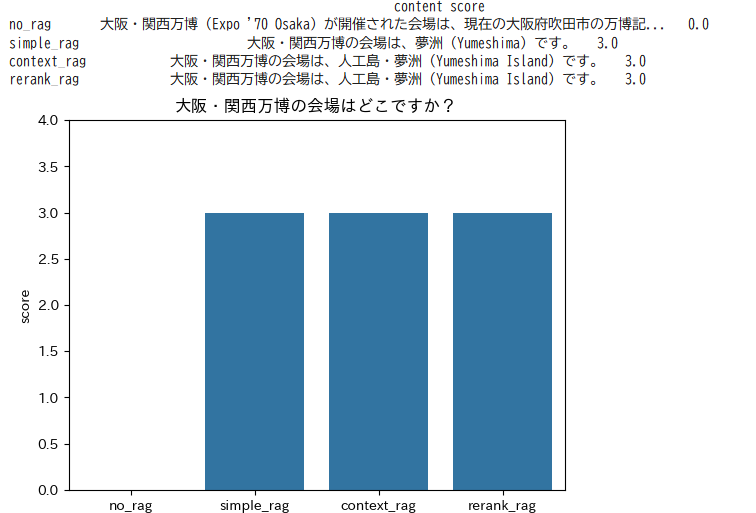

### query = "大阪・関西万博のメインキャラクターは何ですか？"

In [ ]:
query = "大阪・関西万博のメインキャラクターは何ですか？"
gold_answer = "ミャクミャクです。"

In [ ]:
results = {}

rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, texts)
    print("*"*60)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')
    print("*"*60)

In [ ]:
df = pd.DataFrame(results).T
print(df)
sns.barplot(x=df.index, y="score", data=df)
plt.title(query)
plt.ylim(0, 4)
plt.show()

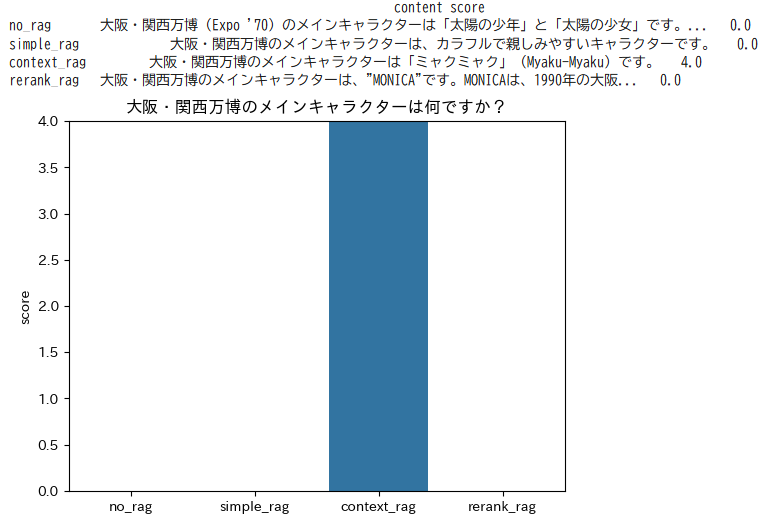

### query = "大阪・関西万博のマスコットは何ですか？"

In [ ]:
query = "大阪・関西万博のマスコットは何ですか？"
gold_answer = "ミャクミャクです。"

In [ ]:
results = {}

rag_types = [no_rag, simple_rag, context_rag, rerank_rag]
def evaluate_all(rag_type,query, gold_answer, tests):
    if rag_type == no_rag:
        response,ref = no_rag(query)
    else:
        response,ref = rag_type(query,tests)
    score = evaluate_answer_accuracy(query, response, gold_answer)
    results[rag_type.__name__] = {}
    results[rag_type.__name__]["content"] = response
    results[rag_type.__name__]["score"] = score
    return results,ref

for rag_type in rag_types:
    results,ref = evaluate_all(rag_type,query, gold_answer, texts)
    print("*"*60)
    print(rag_type.__name__)
    print(f"[references]\n{ref}")
    print(f'[result]\n{results[rag_type.__name__]["content"]}')
    print(f'[score]\n{results[rag_type.__name__]["score"]}')
    print("*"*60)

In [ ]:
df = pd.DataFrame(results).T
print(df)
sns.barplot(x=df.index, y="score", data=df)
plt.title(query)
plt.ylim(0, 4)
plt.show()

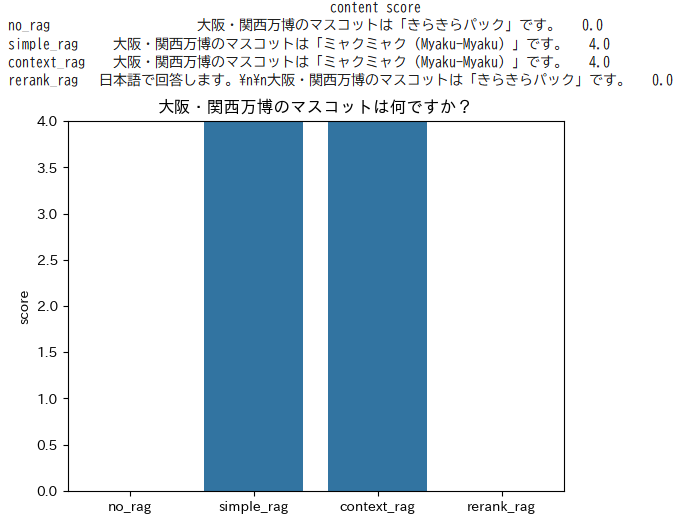